In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0waCDM, LambdaCDM, FlatLambdaCDM
from astropy import constants

import os
import sys

#from bed.grid import Grid, GridStack
#from bed.design import ExperimentDesigner

sys.path.append('/home/ashandonay/bed/bayesdesign/src/bed/')
from grid import Grid, GridStack
from design import ExperimentDesigner

import pandas as pd
from scipy.integrate import quad, cumulative_trapezoid


In [3]:
class bed_cosmology:

    def __init__(self, cosmo_params, sigma_D_H=0.2, sigma_D_M=0.2, include_D_M=False, iterate=False):
        self.cosmo_params = set(cosmo_params.names)
        self.sigma_D_H = sigma_D_H
        self.sigma_D_M = sigma_D_M
        self.include_D_M = include_D_M
        self.r_drag = 149.77
        self.H0 = Planck18.H0.value
        self.coeff = constants.c.to('km/s').value/(self.H0*self.r_drag)
        self.iterate = iterate
    
    def D_H_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            return self.coeff/np.sqrt(Om * (1+z)**3 + (1-Om))

        elif self.cosmo_params == {'Om', 'w0'}:
            return self.coeff/np.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+w0)))

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            return self.coeff/np.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+(w0+wa*(z/(1+z))))))
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")

    def D_M_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            return self.coeff * cumulative_trapezoid(1 / np.sqrt(Om * (1 + z)**3 + (1 - Om)), z, initial=0, axis=0)

        elif self.cosmo_params == {'Om', 'w0'}:
            return self.coeff * cumulative_trapezoid(1 / np.sqrt(Om * (1 + z)**3 + (1 - Om) * (1 + z)**(3 * (1 + w0))), z, initial=0, axis=0)

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            return self.coeff * cumulative_trapezoid(1 / np.sqrt(Om * (1 + z)**3 + (1 - Om) * (1 + z)**(3 * (1 + (w0 + wa * (z / (1 + z)))))), z, initial=0, axis=0)
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")
    
    def likelihood(self, params, features, designs):
        with GridStack(features, designs, params):
            # create a dictionary of the parameters
            kwargs = { }
            for key in params.names:
                kwargs[key] = getattr(params, key)

            D_H_mean = self.D_H_func(designs.z, **kwargs)
            D_H_diff = features.D_H - D_H_mean
            D_H_likelihood = np.exp(-0.5 * (D_H_diff / self.sigma_D_H) ** 2) 

            if self.include_D_M:
                D_M_mean = self.D_M_func(designs.z, **kwargs)
                D_M_diff = features.D_M - D_M_mean
                D_M_likelihood = np.exp(-0.5 * (D_M_diff / self.sigma_D_M) ** 2)
                likelihood = D_H_likelihood * D_M_likelihood
            else:
                likelihood = D_H_likelihood
            features.normalize(likelihood)
        return likelihood

    def likelihood_func(self, params, features, designs):
        # create a dictionary of the parameters
        kwargs = { }
        for key in params.names:
            kwargs[key] = getattr(params, key)

        D_H_mean = self.D_H_func(designs.z, **kwargs)
        D_H_diff = features.D_H - D_H_mean
        D_H_likelihood = np.exp(-0.5 * (D_H_diff / self.sigma_D_H) ** 2) 

        if self.include_D_M:
            D_M_mean = self.D_M_func(designs.z, **kwargs)
            D_M_diff = features.D_M - D_M_mean
            D_M_likelihood = np.exp(-0.5 * (D_M_diff / self.sigma_D_M) ** 2)
            likelihood = D_H_likelihood * D_M_likelihood
        else:
            likelihood = D_H_likelihood
        return likelihood

In [4]:
r_drag = 149.77
H0 = Planck18.H0.value
coeff = constants.c.to('km/s').value/(H0*r_drag)

In [5]:
import psutil

In [ ]:
designs = Grid(z=np.linspace(0, 5, 100))
params = Grid(Om=np.linspace(0.2, 0.4, 100))#, w0=np.linspace(-1.5, -0.5, 100), wa=np.linspace(-1, 1, 100))
features = Grid(D_H=np.linspace(0.1, 30, 100))

cosmo = bed_cosmology(params, sigma_D_H=1.5, sigma_D_M=0.2, include_D_M=False)

#likelihood = cosmo.likelihood(params, features, designs)
prior = np.ones(params.shape)
params.normalize(prior);
process = psutil.Process(os.getpid())
print(process)
memory_usage = process.memory_info().rss  # in bytes
print(f"Memory Usage: {memory_usage / (1024 * 1024):.2f} MB")

designer = ExperimentDesigner(params, features, designs, cosmo.likelihood_func)
designer.calculateEIG(prior)
designer.describe()

psutil.Process(pid=1583850, name='python', status='running', started='18:02:51')
Memory Usage: 197.89 MB
psutil.Process(pid=1583850, name='python', status='running', started='18:02:51')
Memory Usage 0: 197.89 MB
Memory Usage 1: 197.89 MB
Memory Usage 2: 206.05 MB
Memory Usage 3: 213.58 MB
Memory Usage 4: 213.58 MB
Memory Usage 5: 213.58 MB
Memory Usage 6: 213.82 MB
GRID           designs [100:z]
GRID          features [100:D_H]
GRID        parameters [100:Om]
ARRAY            prior (100,)                           0.0 Mb
ARRAY       likelihood (100, 100, 100)                  7.6 Mb
ARRAY         marginal (100, 100)                       0.1 Mb
ARRAY               IG (100, 100)                       0.1 Mb
ARRAY              EIG (100,)                           0.0 Mb


In [9]:
220.05 - 197.42

22.630000000000024

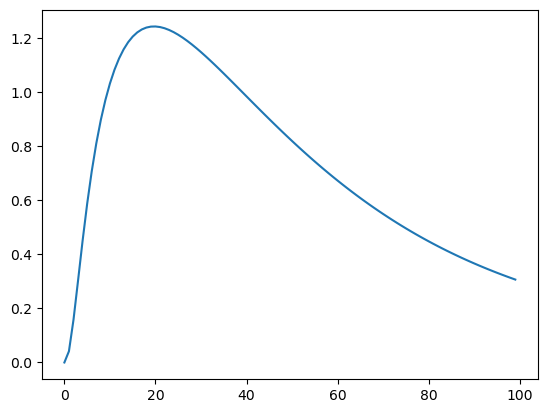

In [8]:
plt.plot(designer.EIG)
plt.show()

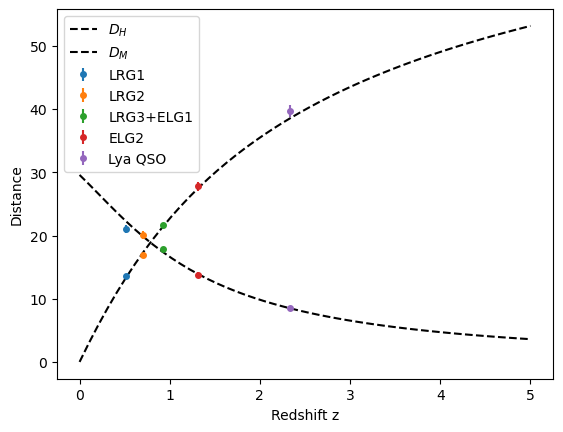

In [4]:
desi_df = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
Om_params = Grid(Om=np.linspace(0.2, 0.4, 51))
cosmo = bed_cosmology(Om_params)
z = np.linspace(0, 5, 50)
tracers = desi_df['tracer'].unique()
for t in tracers:
    tracer_vals = desi_df[desi_df['tracer'] == t]
    plt.errorbar(tracer_vals['z'], tracer_vals['value_at_z'], yerr=tracer_vals['std'], fmt='.', label=t, markersize=8)
plt.plot(z, cosmo.D_H_func(z,Planck18.Om0), label='$D_H$', linestyle='--', color="black")
plt.plot(z, cosmo.D_M_func(z,Planck18.Om0), label='$D_M$', linestyle='--', color="black")
plt.xlabel('Redshift z')
plt.ylabel('Distance')
plt.legend()
plt.show()

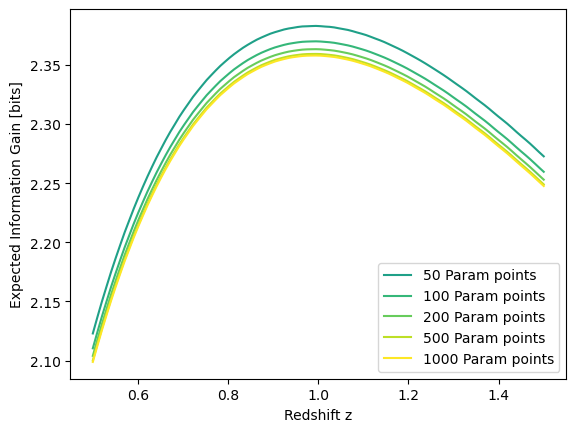

In [73]:
plt.figure()
cmap = plt.get_cmap('viridis')
for i in [50, 100, 200, 500, 1000]:
    designs = Grid(z=np.linspace(0.5, 1.5, 100))
    features = Grid(D_H=np.linspace(0.1, 40, 120))
    params = Grid(Om=np.linspace(0.2, 0.4, i))

    cosmo = bed_cosmology(
        params,
        sigma_D_H=0.2,
        sigma_D_M=0.2,
        include_D_M=False
        )

    likelihood = cosmo.likelihood(params, features, designs)

    prior = np.ones(params.shape)
    params.normalize(prior);

    designer = ExperimentDesigner(params, features, designs, likelihood)
    designer.calculateEIG(prior)
    plt.plot(designs.z, designer.EIG, label=f'{i} Param points', color=cmap(np.log(i)/np.log(1000)))
plt.xlabel('Redshift z')
plt.ylabel('Expected Information Gain [bits]')
plt.legend()
plt.show()

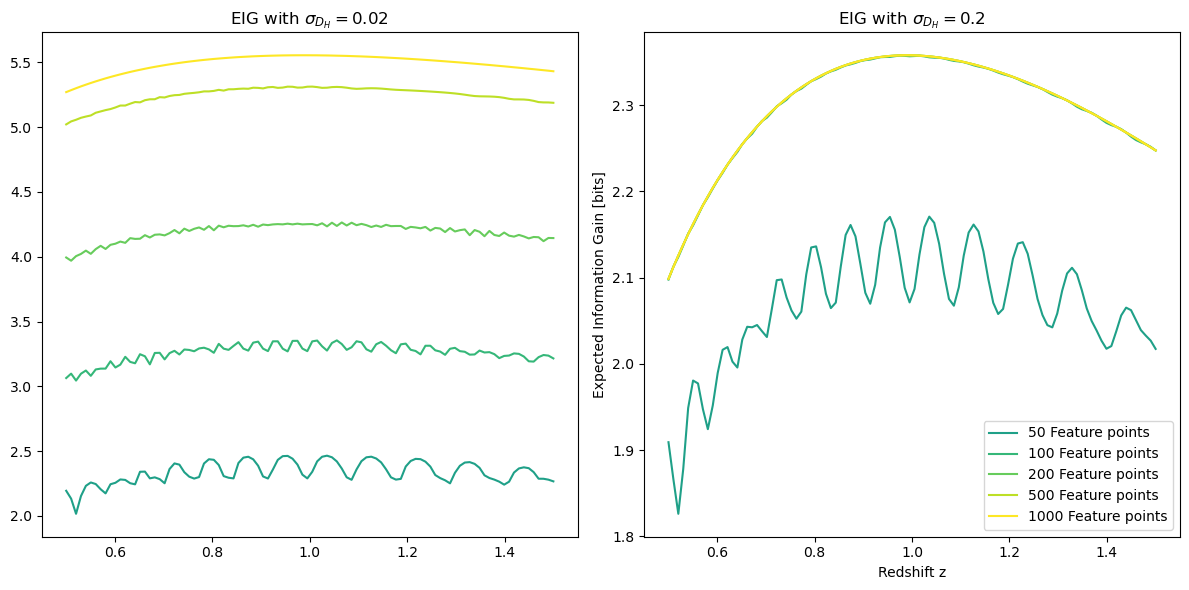

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
cmap = plt.get_cmap('viridis')
designs = Grid(z=np.linspace(0.5, 1.5, 100))
params = Grid(Om=np.linspace(0.2, 0.4, 1000))
for i in [50, 100, 200, 500, 1000]:
    features = Grid(D_H=np.linspace(0.1, 40, i))

    cosmo = bed_cosmology(
        params,
        sigma_D_H=0.02,
        sigma_D_M=0.02,
        include_D_M=False
        )

    likelihood = cosmo.likelihood(params, features, designs)

    prior = np.ones(params.shape)
    params.normalize(prior);

    designer = ExperimentDesigner(params, features, designs, likelihood)
    designer.calculateEIG(prior)
    ax1.plot(designs.z, designer.EIG, color=cmap(np.log(i)/np.log(1000)))
ax1.set_title('EIG with $\sigma_{D_H} = 0.02$')

for i in [50, 100, 200, 500, 1000]:
    features = Grid(D_H=np.linspace(0.1, 40, i))

    cosmo = bed_cosmology(
        params,
        sigma_D_H=0.2,
        sigma_D_M=0.2,
        include_D_M=False
        )

    likelihood = cosmo.likelihood(params, features, designs)

    prior = np.ones(params.shape)
    params.normalize(prior);

    designer = ExperimentDesigner(params, features, designs, likelihood)
    designer.calculateEIG(prior)
    ax2.plot(designs.z, designer.EIG, label=f'{i} Feature points', color=cmap(np.log(i)/np.log(1000)))
ax2.set_title('EIG with $\sigma_{D_H} = 0.2$')
plt.xlabel('Redshift z')
plt.ylabel('Expected Information Gain [bits]')
plt.legend()
plt.tight_layout()
plt.show()

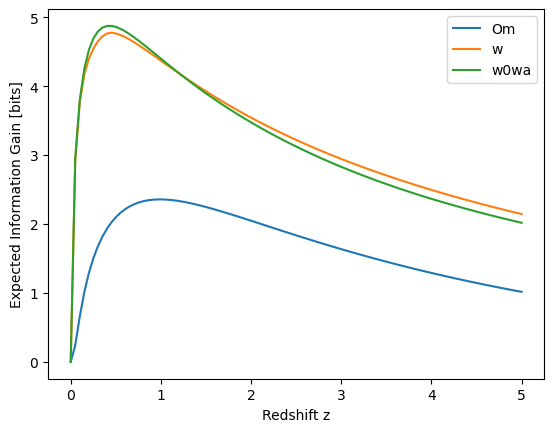

In [6]:
plt.plot(np.load('grid_Om_eigs.npy')[:,0], np.load('grid_Om_eigs.npy')[:,1], label='Om')
plt.plot(np.load('grid_w_eigs.npy')[:,0], np.load('grid_w_eigs.npy')[:,1], label='w')
plt.plot(np.load('grid_w0wa_eigs.npy')[:,0], np.load('grid_w0wa_eigs.npy')[:,1], label='w0wa')
plt.legend()
plt.xlabel('Redshift z')
plt.ylabel('Expected Information Gain [bits]')
plt.show()

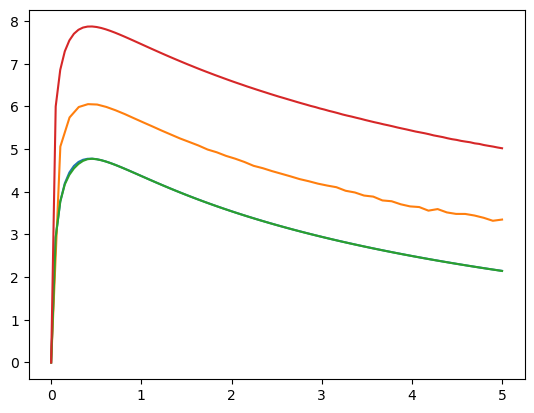

In [5]:
plt.plot(np.load('grid_w_eigs_2.npy')[:,0], np.load('grid_w_eigs_2.npy')[:,1])
plt.plot(np.load('grid_w_eigs.npy')[:,0], np.load('grid_w_eigs.npy')[:,1])
plt.plot(np.load('grid_w_eigs_3.npy')[:,0], np.load('grid_w_eigs_3.npy')[:,1])
plt.plot(np.load('grid_w0_eigs.npy')[:,0], np.load('grid_w0_eigs.npy')[:,1])
plt.show()

In [9]:
designs = Grid(z=np.linspace(0, 5, 100))
Om_params = Grid(Om=np.linspace(0.2, 0.4, 2000))

include_D_M = False
if include_D_M:
    features = Grid(D_H=np.linspace(0.1, 40, 120), D_M=np.linspace(0.1, 80, 120))
else:
    features = Grid(D_H=np.linspace(0.1, 40, 2020))

Om_cosmo = bed_cosmology(
    Om_params,
    sigma_D_H=0.02,
    sigma_D_M=0.02,
    include_D_M=include_D_M
    )

Om_likelihood = Om_cosmo.likelihood(Om_params, features, designs)

prior = np.ones(Om_params.shape)
Om_params.normalize(prior);

Om_designer = ExperimentDesigner(Om_params, features, designs, Om_likelihood)
Om_designer.calculateEIG(prior)
Om_designer.describe()

GRID       designs [100:z]
GRID      features [2020:D_H]
GRID    parameters [2000:Om]
ARRAY        prior (2000,)                    0.0 Mb
ARRAY   likelihood (2020, 100, 2000)       3082.3 Mb
ARRAY    posterior (2020, 100, 2000)       3082.3 Mb
ARRAY     marginal (2020, 100)                1.5 Mb
ARRAY           IG (2020, 100)                1.5 Mb
ARRAY          EIG (100,)                     0.0 Mb


In [6]:
designs = Grid(z=np.linspace(0, 5, 25))
w_params = Grid(Om=np.linspace(0.2, 0.4, 501), w0=np.linspace(-3, 1, 501))

include_D_M = False
if include_D_M:
    features = Grid(D_H=np.linspace(0.1, 40, 120), D_M=np.linspace(0.1, 80, 120))
else:
    features = Grid(D_H=np.linspace(0.1, 40, 320))

w_cosmo = bed_cosmology(
    w_params,
    sigma_D_H=0.02,
    sigma_D_M=0.02,
    include_D_M=include_D_M,
    iterate=True
    )

w_likelihood = w_cosmo.likelihood(w_params, features, designs)

prior = np.ones(w_params.shape)
w_params.normalize(prior);

w_designer = ExperimentDesigner(w_params, features, designs, w_likelihood)
w_designer.calculateEIG(prior)
w_designer.describe()

{'z': 0.4166666666666667}

In [4]:
designs = Grid(z=np.linspace(0, 5, 100))
w0wa_params = Grid(Om=np.linspace(0.2, 0.4, 100), w0=np.linspace(-3, 1, 100), wa=np.linspace(-3, 2, 100))

include_D_M = True
if include_D_M:
    features = Grid(D_H=np.linspace(0.1, 40, 220), D_M=np.linspace(0.1, 80, 220))
else:
    features = Grid(D_H=np.linspace(0.1, 40, 320))

w0wa_cosmo = bed_cosmology(
    w0wa_params,
    sigma_D_H=0.2,
    sigma_D_M=0.2,
    include_D_M=include_D_M,
    )

w0wa_likelihood = w0wa_cosmo.likelihood(w0wa_params, features, designs)

prior = np.ones(w0wa_params.shape)
w0wa_params.normalize(prior);

w0wa_designer = ExperimentDesigner(w0wa_params, features, designs, w0wa_likelihood)
w0wa_designer.calculateEIG(prior, debug=False)
w0wa_designer.describe()

: 

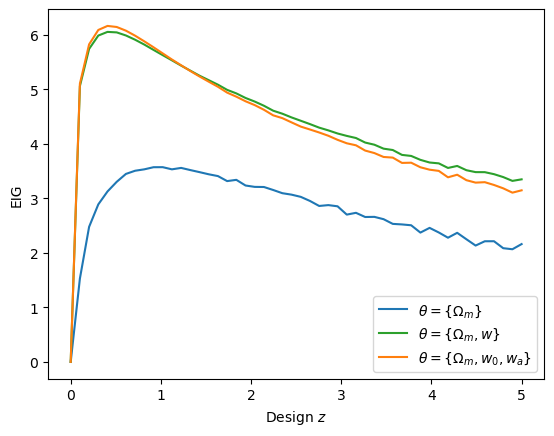

In [14]:
plt.plot(designs.z, Om_designer.EIG, label='$\\theta = \{\Omega_m\}$', color='tab:blue')
plt.plot(designs.z, w_designer.EIG, label='$\\theta = \{\Omega_m,w\}$', color='tab:green')
plt.plot(designs.z, w0wa_designer.EIG, label='$\\theta = \{\Omega_m, w_0, w_a \}$', color='tab:orange')
plt.xlabel('Design $z$')
plt.ylabel('EIG')
plt.legend(loc='lower right')
plt.show()

In [15]:
#np.save('grid_Om_eigs.npy', np.stack((designs.z, Om_designer.EIG), axis=1))
#np.save('grid_w_eigs.npy', np.stack((designs.z, w0_designer.EIG), axis=1))
#np.save('grid_w0wa_eigs.npy', np.stack((designs.z, wa_designer.EIG), axis=1))

In [4]:
pd.read_csv('/home/ashandonay/bed/desi_data.csv')

,tracer,num,z,value_at_z,std,quantity
0,LRG1,506905,0.510,13.620031,0.251925,DM_over_rs
1,LRG1,506905,0.510,20.983346,0.610712,DH_over_rs
2,LRG2,771875,0.706,16.846453,0.319336,DM_over_rs
3,LRG2,771875,0.706,20.078729,0.595356,DH_over_rs
4,LRG3+ELG1,1876164,0.930,21.708418,0.282077,DM_over_rs
5,LRG3+ELG1,1876164,0.930,17.876129,0.346317,DH_over_rs
6,ELG2,1415687,1.317,27.787208,0.690340,DM_over_rs
7,ELG2,1415687,1.317,13.823723,0.422221,DH_over_rs
8,Lya QSO,709565,2.330,39.708383,0.943267,DM_over_rs
9,Lya QSO,709565,2.330,8.522566,0.170839,DH_over_rs


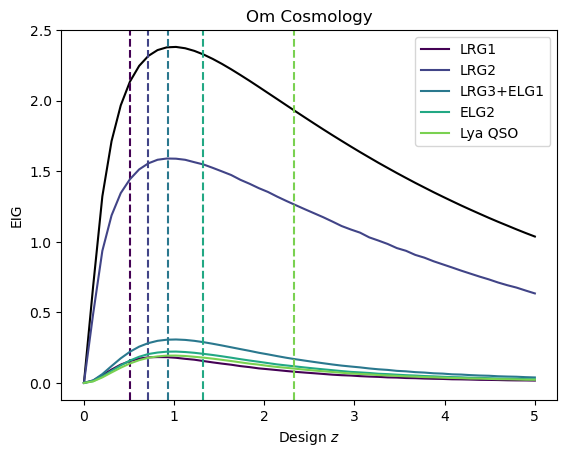

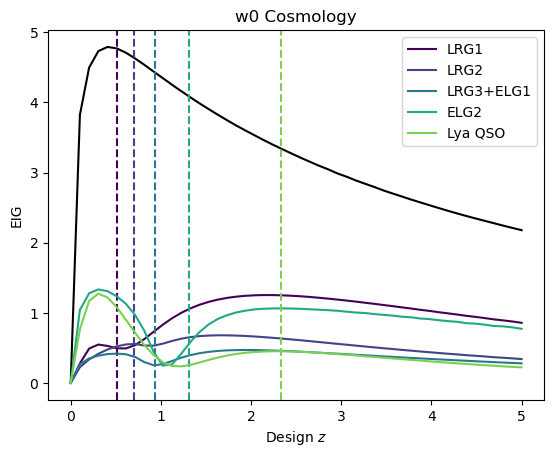

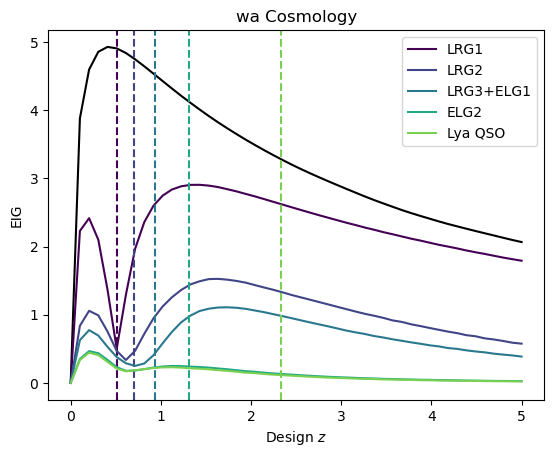

In [30]:
desi_df = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
cmap = plt.get_cmap('viridis')
cosmologies = #['Om', 'w0', 'wa']
tracers = desi_df['tracer'].unique()
for c in cosmologies:
    if c == "Om":
        prior = np.ones(Om_params.shape)
        Om_params.normalize(prior);
        Om_designer = ExperimentDesigner(Om_params, features, designs, Om_likelihood)
        Om_designer.calculateEIG(prior)
        plt.figure()
        plt.plot(designs.z, Om_designer.EIG, color='black')
        for i,t in enumerate(tracers):
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                Om_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                Om_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=cmap(i/len(tracers)))
            plt.plot(designs.z, Om_designer.EIG, color=cmap(i/len(tracers)), label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.show()
    elif c == "w":
        prior = np.ones(w_params.shape)
        w_params.normalize(prior);
        w_designer = ExperimentDesigner(w_params, features, designs, w0_likelihood)
        w_designer.calculateEIG(prior)
        plt.figure()
        plt.plot(designs.z, w_designer.EIG, color='black')
        for i,t in enumerate(tracers):
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                w_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                w_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=cmap(i/len(tracers)))
            plt.plot(designs.z, w_designer.EIG, color=cmap(i/len(tracers)), label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.show()
    elif c == "wa":
        prior = np.ones(w0wa_params.shape)
        w0wa_params.normalize(prior);
        w0wa_designer = ExperimentDesigner(w0wa_params, features, designs, wa_likelihood)
        w0wa_designer.calculateEIG(prior)
        plt.figure()
        plt.plot(designs.z, w0wa_designer.EIG, color='black')
        for i,t in enumerate(tracers):
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                w0wa_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                w0wa_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=cmap(i/len(tracers)))
            plt.plot(designs.z, w0wa_designer.EIG, color=cmap(i/len(tracers)), label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.show()

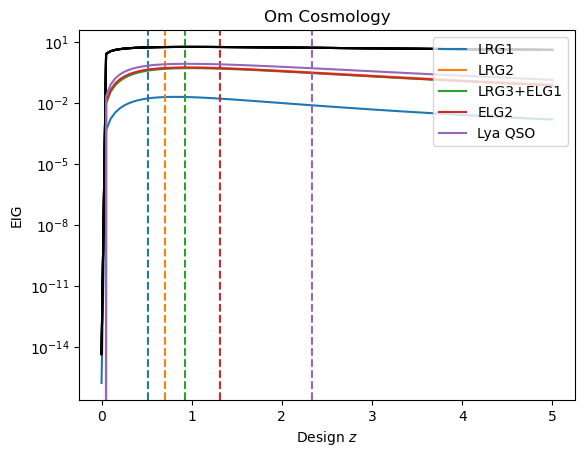

In [11]:
desi_df = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
cosmologies = ['Om'] #, ['Om', 'w', 'w0wa']
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for c in cosmologies:
    tracers = desi_df['tracer'].unique()
    if c == 'Om':
        for i,t in enumerate(tracers):
            prior = np.ones(Om_params.shape)
            Om_params.normalize(prior);
            Om_designer = ExperimentDesigner(Om_params, features, designs, Om_likelihood)
            Om_designer.calculateEIG(prior)
            plt.plot(designs.z, Om_designer.EIG, color='black')
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                Om_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                Om_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=colors[i])
            plt.plot(designs.z, Om_designer.EIG, color=colors[i], label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.yscale('log')
        plt.show()
        
    elif c == 'w':
        for i,t in enumerate(tracers):
            prior = np.ones(w_params.shape)
            w_params.normalize(prior);
            w_designer = ExperimentDesigner(w_params, features, designs, w0_likelihood)
            w_designer.calculateEIG(prior)
            plt.plot(designs.z, w_designer.EIG, color='black')
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                w_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                w_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=colors[i])
            plt.plot(designs.z, w_designer.EIG, color=colors[i], label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.show()

    elif c == 'w0wa':
        for i,t in enumerate(tracers):
            prior = np.ones(w0wa_params.shape)
            w0wa_params.normalize(prior);
            w0wa_designer = ExperimentDesigner(w0wa_params, features, designs, w0wa_likelihood)
            w0wa_designer.calculateEIG(prior)
            plt.plot(designs.z, w0wa_designer.EIG, color='black')
            tracer_vals = desi_df[desi_df['tracer'] == t]
            if include_D_M:
                w0wa_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0],
                                    "D_M": tracer_vals.loc[tracer_vals['quantity'] == 'DM_over_rs', 'value_at_z'].values[0]});
            else:
                w0wa_designer.update(**{"z": tracer_vals['z'].values[0], 
                                    "D_H": tracer_vals.loc[tracer_vals['quantity'] == 'DH_over_rs', 'value_at_z'].values[0]});
            plt.axvline(x=tracer_vals['z'].values[0], linestyle='--', color=colors[i])
            plt.plot(designs.z, w0wa_designer.EIG, color=colors[i], label=t)
        plt.xlabel('Design $z$')
        plt.ylabel('EIG')
        plt.legend(loc="upper right")
        plt.title(c + ' Cosmology')
        plt.show()